# Debugging mapper
Big in Japan - Alphaville

In [13]:
%load_ext autoreload
%autoreload 2
import tools_EEG as TEGG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from datetime import datetime, timedelta

folder_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/"

# ------------------------
# 1) Count .mat files
# ------------------------
all_files = os.listdir(folder_path)

mat_files = [
    f for f in all_files
    if f.lower().endswith(".mat") and not f.startswith(".")
]

print(f"Total files in folder: {len(all_files)}")
print(f"MAT files (non-hidden): {len(mat_files)}")

# (Optional) for reproducibility: keep a deterministic listing order
mat_files_sorted_by_name = sorted(mat_files)

# ------------------------
# 2) Extract T0/TF
# ------------------------
resultados = []
errors = []

for i, filename in enumerate(mat_files_sorted_by_name):
    file_path = os.path.join(folder_path, filename)

    try:
        data_mat = loadmat(file_path)
        hdr = data_mat["hdr"]

        # T0: expected format like [[2019, 10, 30, 1, 54, 13]]
        t0_raw = hdr["orig"][0, 0]["T0"][0, 0][0]
        t0_dt = datetime(
            int(t0_raw[0]), int(t0_raw[1]), int(t0_raw[2]),
            int(t0_raw[3]), int(t0_raw[4]), int(t0_raw[5])
        )

        fs = float(hdr["Fs"][0, 0].item())
        signal = np.asarray(data_mat["data"])

        channels_raw = hdr["label"][0, 0]
        n_channels = channels_raw.shape[0]

        # Ensure shape: (n_samples, n_channels)
        if signal.ndim == 2:
            if signal.shape[1] != n_channels and signal.shape[0] == n_channels:
                signal = signal.T
        else:
            raise ValueError(f"Unexpected signal ndim={signal.ndim} shape={signal.shape}")

        n_samples = signal.shape[0]
        duracion_segundos = n_samples / fs
        tf_dt = t0_dt + timedelta(seconds=duracion_segundos)

        resultados.append({
            "list_idx": i,              # order in the loop (by filename sorting)
            "file": filename,
            "T0": t0_dt,
            "TF": tf_dt,
            "time (s)": duracion_segundos
        })

    except Exception as e:
        errors.append((filename, str(e)))

print(f"\nProcessed OK: {len(resultados)} / {len(mat_files_sorted_by_name)}")
print(f"Errors: {len(errors)}")
if errors:
    print("\nFirst 5 errors:")
    for fn, msg in errors[:5]:
        print(f"  - {fn}: {msg}")

df = pd.DataFrame(resultados)

# ------------------------
# 3) Check T0 order
# ------------------------
# A) Is T0 monotonic in current iteration order?
df_in_loop_order = df.sort_values("list_idx").reset_index(drop=True)
is_mono_loop = df_in_loop_order["T0"].is_monotonic_increasing
print(f"\nT0 monotonic in loop order (by filename-sorted order): {is_mono_loop}")

if not is_mono_loop:
    # show where it breaks
    breaks = df_in_loop_order["T0"].diff().dt.total_seconds() < 0
    print("\nBreakpoints (where T0 goes backwards) - showing up to 10:")
    bad_rows = df_in_loop_order[breaks].head(10)
    print(bad_rows[["file", "T0"]])

# B) Sort by T0 and confirm monotonic
df_sorted = df.sort_values("T0").reset_index(drop=True)
is_mono_sorted = df_sorted["T0"].is_monotonic_increasing
print(f"\nT0 monotonic after sorting by T0: {is_mono_sorted}")

# If there are duplicates/equal T0s, it will still be monotonic, but worth flagging:
dup_t0 = df_sorted["T0"].duplicated().sum()
print(f"Duplicate T0 count: {dup_t0}")

# Quick look
print("\nFirst 10 rows sorted by T0:")
print(df_sorted[["file", "T0", "TF", "time (s)"]].head(10))

# ------------------------
# 4) Gap calc (same as you had, but keep full precision first)
# ------------------------
df_sorted["Gap (s)"] = (df_sorted["T0"] - df_sorted["TF"].shift(1)).dt.total_seconds().fillna(0)

gaps_significativos = df_sorted[df_sorted["Gap (s)"] > 1]
print(f"\nFound {len(gaps_significativos)} gaps > 1s")

# Optional: show top gaps
if len(gaps_significativos) > 0:
    print("\nTop 10 gaps:")
    print(gaps_significativos[["file", "T0", "Gap (s)"]].sort_values("Gap (s)", ascending=False).head(10))

Total files in folder: 370
MAT files (non-hidden): 183

Processed OK: 183 / 183
Errors: 0

T0 monotonic in loop order (by filename-sorted order): False

Breakpoints (where T0 goes backwards) - showing up to 10:
             file                  T0
2   XB47Y_100.mat 2019-10-30 19:47:44
13  XB47Y_110.mat 2019-11-06 07:42:43
24  XB47Y_120.mat 2019-11-11 03:25:02
35  XB47Y_130.mat 2019-11-16 17:25:56
46  XB47Y_140.mat 2019-11-22 20:04:35
52  XB47Y_146.mat 2019-11-08 07:09:40
57  XB47Y_150.mat 2019-11-27 13:41:29
68  XB47Y_160.mat 2019-12-01 14:13:12
78   XB47Y_17.mat 2019-12-03 03:52:00
89   XB47Y_18.mat 2019-12-04 09:52:32

T0 monotonic after sorting by T0: True
Duplicate T0 count: 0

First 10 rows sorted by T0:
            file                  T0                         TF     time (s)
0   XB47Y_35.mat 2019-10-29 09:31:04 2019-10-29 10:01:00.730450   1796.73045
1   XB47Y_37.mat 2019-10-29 19:54:13 2019-10-30 01:54:12.759550  21599.75955
2   XB47Y_38.mat 2019-10-30 01:54:13 2019-10-30 0

In [15]:
path = "//home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/"
df_XB47Y, error_list = TEGG.process_eeg_mat_files(path)
print(df_XB47Y.head())

--- Processing Summary ---
Successfully processed: 183
Errors encountered: 0
Total significant gaps (>1s): 78
   list_idx          file                  T0                         TF  \
0       112  XB47Y_35.mat 2019-10-29 09:31:04 2019-10-29 10:01:00.730450   
1       114  XB47Y_37.mat 2019-10-29 19:54:13 2019-10-30 01:54:12.759550   
2       115  XB47Y_38.mat 2019-10-30 01:54:13 2019-10-30 04:58:50.338150   
3       181  XB47Y_98.mat 2019-10-30 07:47:44 2019-10-30 13:47:44.759400   
4       182  XB47Y_99.mat 2019-10-30 13:47:44 2019-10-30 19:47:44.759400   

    duration_s        gap_s  
0   1796.73045      0.00000  
1  21599.75955  35592.26955  
2  11077.33815      0.24045  
3  21600.75940  10133.66185  
4  21600.75940     -0.75940  


In [3]:
signal = np.asarray(data_mat["data"])

print("type(signal):", type(signal))
print("signal.ndim:", signal.ndim)
print("signal.shape:", signal.shape)
print("signal.dtype:", signal.dtype)

# Muestra una mini-ventana del array (primeras 5 filas x primeras 5 cols)
if signal.ndim == 2:
    print("signal[:5, :5] =\n", signal[:5, :5])
elif signal.ndim == 1:
    print("signal[:10] =", signal[:10])
else:
    print("signal sample slice:", signal.ravel()[:10])



type(signal): <class 'numpy.ndarray'>
signal.ndim: 2
signal.shape: (2, 4472028)
signal.dtype: float64
signal[:5, :5] =
 [[-13.42000977 -14.76201074  -6.71000488   0.          -1.34200098]
 [  4.69700342   7.38100537  10.06500733  11.4070083   10.73600781]]


Cada fila es un canal \
Cada columna es un instante de tiempo


Hours per .mat file
Mean   : 4.419 h
Median : 6.000 h
Min/Max: 0.003 / 6.007 h


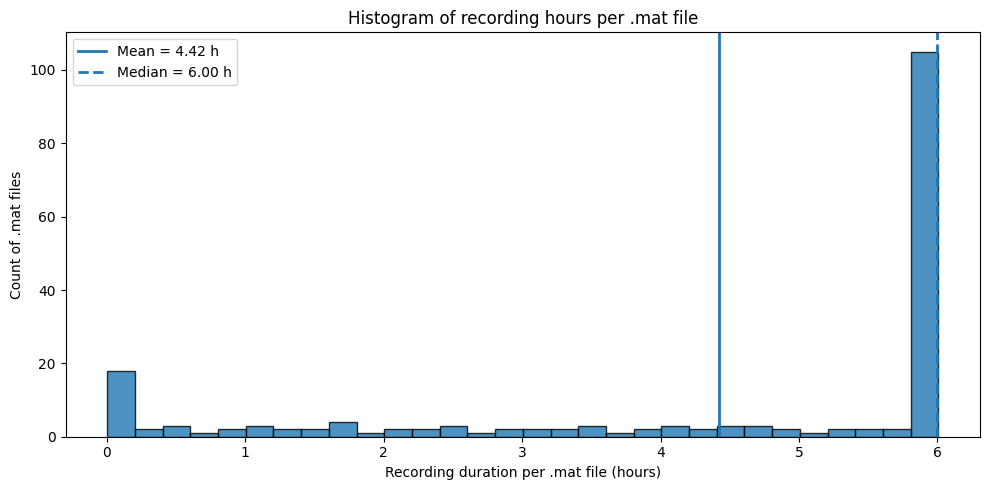

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- elegir qué DF usar ---
# Si querés por archivo tal cual procesaste:
df_use = df.copy()

# Si preferís el orden cronológico (no afecta histograma, pero por prolijidad):
# df_use = df_sorted.copy()

# --- convertir a horas ---
df_use["hours"] = df_use["time (s)"] / 3600.0

# --- stats ---
mean_h = df_use["hours"].mean()
median_h = df_use["hours"].median()

print(f"\nHours per .mat file")
print(f"Mean   : {mean_h:.3f} h")
print(f"Median : {median_h:.3f} h")
print(f"Min/Max: {df_use['hours'].min():.3f} / {df_use['hours'].max():.3f} h")

# --- histogram ---
plt.figure(figsize=(10,5))
plt.hist(df_use["hours"].dropna(), bins=30, edgecolor="black", alpha=0.8)

# líneas de media/mediana
plt.axvline(mean_h, linewidth=2, label=f"Mean = {mean_h:.2f} h")
plt.axvline(median_h, linewidth=2, linestyle="--", label=f"Median = {median_h:.2f} h")

plt.xlabel("Recording duration per .mat file (hours)")
plt.ylabel("Count of .mat files")
plt.title("Histogram of recording hours per .mat file")
plt.legend()
plt.tight_layout()
plt.show()

median is 6 hours, strange, should be a 18,8h based on what the paper said.

## Computation of TF (Recording End Time)



For each `.mat` EEG file, the end timestamp (`TF`) is computed as follows:

### 1. Extract recording start time (T0)

`T0` is obtained from the file header and converted into a Python `datetime` object.

T0 = datetime(year, month, day, hour, minute, second)

---

### 2. Extract sampling frequency (Fs)

`Fs` represents the number of samples recorded per second (Hz).

Fs = samples per second

---

### 3. Compute recording duration

The total number of samples is obtained from the signal matrix:

n_samples = signal.shape[0]

The duration (in seconds) is:

duration_seconds = n_samples / Fs

---

### 4. Compute recording end time (TF)

The end timestamp is calculated by adding the duration to the start time:

TF = T0 + timedelta(seconds=duration_seconds)

---

### Assumption

The signal is continuously recorded from T0 at constant sampling frequency Fs.

In [5]:
# RED sqEEG
# green diary
import pandas as pd
p_folder_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y"
seizure_file = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/XB47Y_seizures.xlsx"

# Ver nombres de sheets
xls = pd.ExcelFile(seizure_file)
print(xls.sheet_names)

# expected sheets: ['sqEEG', 'diary']
from pathlib import Path
# Creating the folder where the csv are gonna be. each of the resulting sheets


base_dir = Path("/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y")
#patient anon name: eg: xb47y
anon_name = base_dir.name.upper()

folder_name = f"preprocessCSV_{anon_name}"
folder_path = base_dir / folder_name


folder_path.mkdir(parents=True, exist_ok=True)

print(folder_path)
# first data frame for each sheet then I save it as individual csv
# then I can map them separetey to finde the seizures times
df_sqEEG = pd.read_excel(seizure_file, sheet_name="sqEEG")
df_diary = pd.read_excel(seizure_file, sheet_name="diary")

# saved into the folder I created in the prev cell
df_sqEEG.to_csv(folder_path / "sqEEG.csv", index=False)
df_diary.to_csv(folder_path / "diary.csv", index=False)

#df3 = pd.concat([df_diary, df_sqEEG], axis=1)
# no es buena idea concatenarlo porque tienen distinto numero de cosas
#convert each df into a datetime format
df_diary["Timestamp"] = pd.to_datetime(df_diary["Timestamp"])
#df_diary["T"] = pd.to_datetime(df_diary["Timestamp"])
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])


['sqEEG', 'diary']
/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/preprocessCSV_XB47Y


Mostrando estas 5 filas (contiguas por T0):
                   T0                         TF
0 2019-10-29 09:31:04 2019-10-29 10:01:00.730450
1 2019-10-29 19:54:13 2019-10-30 01:54:12.759550
2 2019-10-30 01:54:13 2019-10-30 04:58:50.338150
3 2019-10-30 07:47:44 2019-10-30 13:47:44.759400
4 2019-10-30 13:47:44 2019-10-30 19:47:44.759400


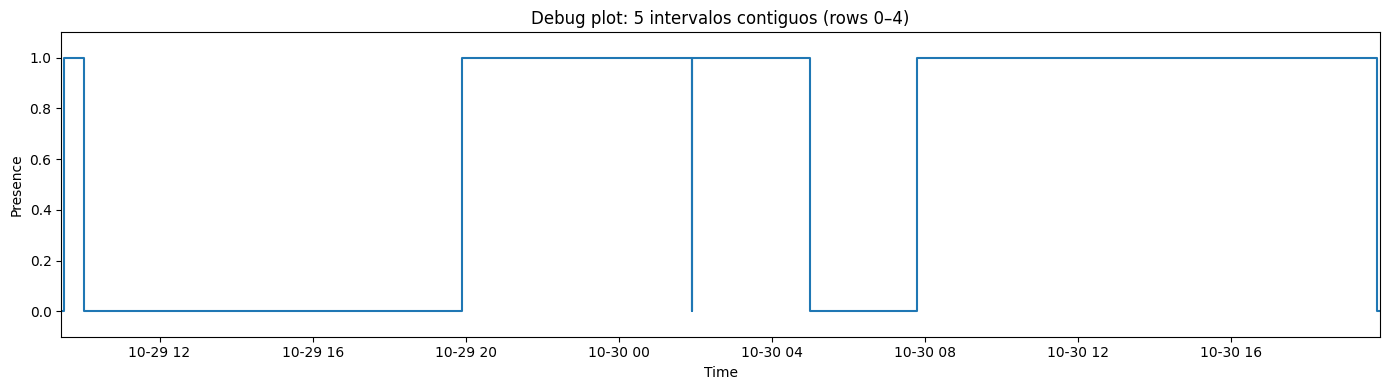

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Asegurar tipos datetime ---
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])

# --- 1) Elegir 5 intervalos contiguos (consecutivos por T0) ---
start_idx = 0  # <- cambiá esto (0, 5, 10, ...)
df_sorted = df.sort_values("T0").reset_index(drop=True)
df_5 = df_sorted.iloc[start_idx:start_idx + 5].copy()

print("Mostrando estas 5 filas (contiguas por T0):")
print(df_5[["T0", "TF"]])

# Rango de tiempo a graficar (un poco de margen)
t_min = df_5["T0"].min() - pd.Timedelta(minutes=5)
t_max = df_5["TF"].max() + pd.Timedelta(minutes=5)

# --- 2) Construir eventos SOLO con esas 5 ---
events = []
for _, row in df_5.iterrows():
    events.append((row["T0"], +1))
    events.append((row["TF"], -1))

events_df = (
    pd.DataFrame(events, columns=["Time", "Delta"])
    .sort_values("Time")
    .groupby("Time", as_index=False)["Delta"].sum()
    .sort_values("Time")
)

events_df["State"] = events_df["Delta"].cumsum()
events_df["Presence"] = (events_df["State"] > 0).astype(int)

# Baseline al inicio del rango (por si el primer evento es después de t_min)
prev_state = events_df.loc[events_df["Time"] < t_min, "State"]
presence_at_start = int(prev_state.iloc[-1] > 0) if len(prev_state) else 0

plot_df = pd.concat(
    [
        pd.DataFrame({"Time": [t_min], "Presence": [presence_at_start]}),
        events_df[["Time", "Presence"]],
        pd.DataFrame({"Time": [t_max], "Presence": [events_df["Presence"].iloc[-1] if len(events_df) else 0]}),
    ],
    ignore_index=True
).sort_values("Time")

# --- 3) Plot: step (como tu código) + onsets dentro del rango ---
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

ax.step(plot_df["Time"], plot_df["Presence"], where="post")
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Presence")
ax.set_xlabel("Time")
ax.set_title(f"Debug plot: 5 intervalos contiguos (rows {start_idx}–{start_idx+4})")
ax.set_xlim(t_min, t_max)

# Onsets en ese rango
onsets_in_range = df_sqEEG[(df_sqEEG["onset"] >= t_min) & (df_sqEEG["onset"] <= t_max)]
for event_time in onsets_in_range["onset"]:
    ax.axvline(event_time, color="red", linestyle="--", linewidth=1.5)

plt.tight_layout()
plt.show()

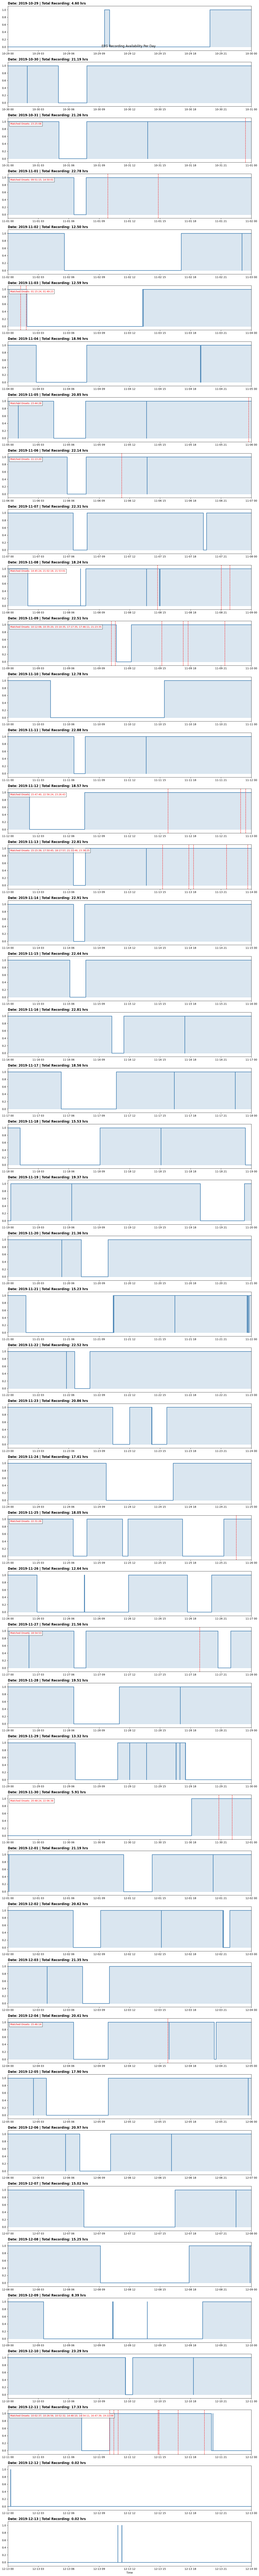

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format (ya lo tenés)
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])

# --- 1) Eventos como deltas (+1 start, -1 end) ---
events = []
for _, row in df.iterrows():
    events.append((row["T0"], +1))
    events.append((row["TF"], -1))

events_df = pd.DataFrame(events, columns=["Time", "Delta"]).sort_values("Time")

# Si hay eventos con el mismo timestamp, los sumamos
events_df = events_df.groupby("Time", as_index=False)["Delta"].sum().sort_values("Time")

# --- 2) Estado acumulado -> presencia binaria ---
events_df["State"] = events_df["Delta"].cumsum()
events_df["Presence"] = (events_df["State"] > 0).astype(int)

# Días (mejor floor que .dt.date)
events_df["DayStart"] = events_df["Time"].dt.floor("D")
unique_days = events_df["DayStart"].unique()

fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)
if len(unique_days) == 1:
    axes = [axes]

for ax, start_day in zip(axes, unique_days):
    start_day = pd.Timestamp(start_day)
    end_day = start_day + pd.Timedelta(days=1)

    # Filtrar datos del día
    day_data = events_df[(events_df["Time"] >= start_day) & (events_df["Time"] < end_day)].copy()

    # Estado inicial y final (para evitar los cortes que mencionabas)
    prev_state = events_df.loc[events_df["Time"] < start_day, "State"]
    presence_at_start = int(prev_state.iloc[-1] > 0) if len(prev_state) else 0
    
    # Re-insertar puntos de control para graficar día completo
    boundary_points = pd.DataFrame({"Time": [start_day, end_day], "Presence": [presence_at_start, None]})
    day_data = pd.concat([day_data[["Time", "Presence"]], boundary_points], ignore_index=True).sort_values("Time")
    day_data["Presence"] = day_data["Presence"].ffill().astype(int)

    # --- 1) CÁLCULO DE DURACIÓN TOTAL EN HORAS ---
    # Calculamos la diferencia de tiempo entre cada fila y la siguiente
    day_data["Duration"] = day_data["Time"].diff().shift(-1)
    # Sumamos solo donde Presence es 1
    total_duration_td = day_data.loc[day_data["Presence"] == 1, "Duration"].sum()
    total_hours = total_duration_td.total_seconds() / 3600

    # --- 2) MATCH DE ONSETS (¿Cae en un registro activo?) ---
    day_marks_seizure = df_sqEEG[(df_sqEEG["onset"] >= start_day) & (df_sqEEG["onset"] < end_day)].copy()
    
    matched_onsets = []
    for _, s_row in day_marks_seizure.iterrows():
        # Buscamos el estado justo en el momento del onset
        state_at_onset = events_df.loc[events_df["Time"] <= s_row["onset"], "Presence"]
        is_captured = state_at_onset.iloc[-1] == 1 if not state_at_onset.empty else False
        if is_captured:
            matched_onsets.append(s_row["onset"].strftime("%H:%M:%S"))

    # --- 3) RECURSOS VISUALES ---
    ax.step(day_data["Time"], day_data["Presence"], where="post", color="steelblue", linewidth=2)
    ax.fill_between(day_data["Time"], day_data["Presence"], step="post", alpha=0.2, color="steelblue")
    
    # Título dinámico con duración
    ax.set_title(f"Date: {start_day.date()} | Total Recording: {total_hours:.2f} hrs", loc='left', fontweight='bold')
    
    # Lista de onsets que matchean (anotación en el gráfico)
    if matched_onsets:
        onset_list_str = "Matched Onsets: " + ", ".join(matched_onsets)
        ax.text(0.01, 0.85, onset_list_str, transform=ax.transAxes, fontsize=9, 
                color="red", bbox=dict(facecolor='white', alpha=0.7))

    for event_time in day_marks_seizure["onset"]:
        ax.axvline(event_time, color="red", linestyle="--", linewidth=1.2)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(start_day, end_day)

    # Onsets del día


axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Per Day")
plt.tight_layout()
plt.savefig(
    "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/results/XB47Y_EEG_recording_availability_per_dayONSET.png",
    dpi=300, bbox_inches="tight"
)
plt.show()


--- Onset Matching Results ---
                     onset  source_file  is_captured  day_total_hours
0  2019-10-31 23:25:08.153  unknown.mat         True            21.26
1  2019-11-01 09:51:15.667  unknown.mat         True            22.78
2  2019-11-01 14:50:01.176  unknown.mat         True            22.78
3  2019-11-03 01:15:24.492  unknown.mat         True            12.59
4  2019-11-03 01:49:23.993  unknown.mat         True            12.59
5  2019-11-05 23:44:28.598  unknown.mat         True            20.85
6  2019-11-06 11:13:20.650  unknown.mat         True            22.14
7  2019-11-08 14:45:24.441  unknown.mat         True            18.24
8  2019-11-08 21:02:18.291  unknown.mat         True            18.24
9  2019-11-08 21:53:01.940  unknown.mat         True            18.24
10 2019-11-09 10:12:08.566  unknown.mat         True            22.51
11 2019-11-09 10:35:20.929  unknown.mat         True            22.51
12 2019-11-09 15:10:35.488  unknown.mat         True       

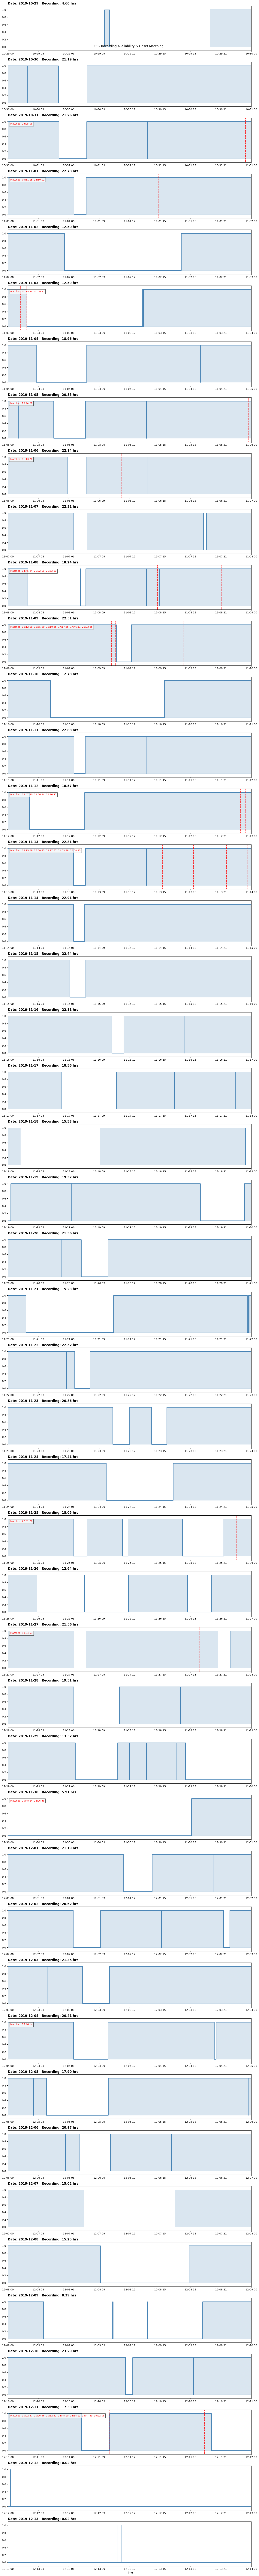

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Setup & Initialization ---
# Assuming df and df_sqEEG are already loaded
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])

# List to store matching results for the final DataFrame
results_list = []

# --- 1) Delta Events (+1 start, -1 end) ---
events = []
for _, row in df.iterrows():
    events.append((row["T0"], +1))
    events.append((row["TF"], -1))

events_df = pd.DataFrame(events, columns=["Time", "Delta"]).sort_values("Time")
events_df = events_df.groupby("Time", as_index=False)["Delta"].sum().sort_values("Time")

# --- 2) Accumulated State -> Binary Presence ---
events_df["State"] = events_df["Delta"].cumsum()
events_df["Presence"] = (events_df["State"] > 0).astype(int)

# Floor timestamps to Day for iteration
events_df["DayStart"] = events_df["Time"].dt.floor("D")
unique_days = events_df["DayStart"].unique()

# --- 3) Plotting & Matching Logic ---
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)
if len(unique_days) == 1:
    axes = [axes]

for ax, start_day in zip(axes, unique_days):
    start_day = pd.Timestamp(start_day)
    end_day = start_day + pd.Timedelta(days=1)

    # Filter data for the specific day
    day_data = events_df[(events_df["Time"] >= start_day) & (events_df["Time"] < end_day)].copy()

    # Boundary handling (initial/final state for the day)
    prev_state = events_df.loc[events_df["Time"] < start_day, "State"]
    presence_at_start = int(prev_state.iloc[-1] > 0) if len(prev_state) else 0
    
    boundary_points = pd.DataFrame({"Time": [start_day, end_day], "Presence": [presence_at_start, None]})
    day_data = pd.concat([day_data[["Time", "Presence"]], boundary_points], ignore_index=True).sort_values("Time")
    day_data["Presence"] = day_data["Presence"].ffill().astype(int)

    # Calculate duration
    day_data["Duration"] = day_data["Time"].diff().shift(-1)
    total_hours = day_data.loc[day_data["Presence"] == 1, "Duration"].sum().total_seconds() / 3600

    # --- THE MATCHING CORE ---
    day_marks_seizure = df_sqEEG[(df_sqEEG["onset"] >= start_day) & (df_sqEEG["onset"] < end_day)].copy()
    
    current_day_matches = []
    for _, s_row in day_marks_seizure.iterrows():
        # Check presence at exact onset time
        state_at_onset = events_df.loc[events_df["Time"] <= s_row["onset"], "Presence"]
        is_captured = state_at_onset.iloc[-1] == 1 if not state_at_onset.empty else False
        
        # Save to our results list
        results_list.append({
            "onset": s_row["onset"],
            "source_file": s_row.get("file", "unknown.mat"), # Adjust "file" to your actual column name
            "is_captured": is_captured,
            "day_total_hours": round(total_hours, 2)
        })

        if is_captured:
            current_day_matches.append(s_row["onset"].strftime("%H:%M:%S"))

    # --- Visuals ---
    ax.step(day_data["Time"], day_data["Presence"], where="post", color="steelblue", linewidth=2)
    ax.fill_between(day_data["Time"], day_data["Presence"], step="post", alpha=0.2, color="steelblue")
    ax.set_title(f"Date: {start_day.date()} | Recording: {total_hours:.2f} hrs", loc='left', fontweight='bold')

    if current_day_matches:
        match_str = "Matched: " + ", ".join(current_day_matches)
        ax.text(0.01, 0.85, match_str, transform=ax.transAxes, fontsize=9, color="red", bbox=dict(facecolor='white', alpha=0.7))

    for event_time in day_marks_seizure["onset"]:
        ax.axvline(event_time, color="red", linestyle="--", linewidth=1.2)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(start_day, end_day)

# --- 4) FINAL DATAFRAME GENERATION ---
df_matched = pd.DataFrame(results_list)

# Display result
print("--- Onset Matching Results ---")
print(df_matched)

axes[-1].set_xlabel("Time")
plt.suptitle("EEG Recording Availability & Onset Matching")
plt.tight_layout()
plt.show()